# Оценка качества синтеза модели Parler-TTS-mini-jenny-30H

https://colab.research.google.com/drive/1Dslguw2_xUFCBtxVSi5_o7kvyfPpOpHE?usp=sharing

Горбунцов Александр

aagorbuntsov@edu.hse.ru

@goralex022

+79167127207

Лучше запускать из Google Colab, весь код выполняется на бесплатной версии T4 примерно 50 минут.

### Определение и описание плана оценки модели

В качестве тестового задания вам предлагается провести оценку качества синтеза модели https://huggingface.co/parler-tts/parler-tts-mini-jenny-30H, которая была дообучена на датасете Jenny.

У датасета Jenny из коробки нет разделения на тренировочный и тестовый датасет, вам необходимо самостоятельно определить сетап для оценки модели: аудиозаписи, метрики, текстовое описание для генерации и тд

Были взяты следующие источники для оценки качества:
* LibriSpeech:
Использовали набор данных LibriSpeech с разделом test-clean, взяли 50 случайных аудиозаписей с текстами из тестовой части. Привели тексты к нижнему регистру для обеспечения корректного распознавания.
* Jenny:
Использовали исходный набор данных Jenny, также выделили небольшую тестовую выборку из 50 случайных аудио.
* Custom Texts:
Создали несколько своих текстов. Использовали разные описания для каждого текста, чтобы оценить влияние описания на качество синтеза, сами тексты отличаются по смыслу и эмоциональной нагрузке.

Планируется оценить:
* Точность произношения: Проверка правильности произношения слов и фраз.
* Грамматическая корректность: Проверка правильности ударения, связности фраз.
* Эмоциональная окраска: Способность модели передавать эмоциональный тон текста.
* Плавность и естественность: Непрерывность и естественность произнесенного текста.
* Соответствие исходному аудио: Степень близости синтезированного аудио к оригинальному.

Для этого были выбраны следующие метрики:
* WER (Word Error Rate): Оценивает точность распознавания сгенерированного аудио.
* DNSMOS (Deep Noise Suppression Mean Opinion Score): Оценивает качество звука и отсутствие шума.
* MCD (Mel-Cepstral Distortion): Измеряет расстояние между мел-цефтроструктурами эталонного и сгенерированного аудио.
* PESQ (Perceptual Evaluation of Speech Quality): Оценивает восприимчивое качество звука.
* STOI (Short-Time Objective Intelligibility): Оценивает интеллектуальную понятность синтезированного аудио.

Общий план решения:
1. Подготовка нужных библиотек и самой модели
2. Ручной анализ крайних случаев
3. Подготовка данных из вышеназванных источников
4. Проведение расчета метрик
5. Визуализация результатов
6. Итоги и вывод

## 1. Подготовка нужных библиотек и самой модели

### Загрузка и импорт библиотек

In [ ]:
!pip install git+https://github.com/huggingface/parler-tts.git -q
!pip install datasets whisper jiwer pystoi pesq fastdtw -q
!pip install -U torchmetrics -q
!pip install librosa onnxruntime-gpu requests -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 101.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torchaudio.datasets import LIBRISPEECH
from datasets import load_dataset
from parler_tts import ParlerTTSForConditionalGeneration
from transformers import AutoTokenizer
import soundfile as sf
import whisper
import jiwer  # Для WER
from pystoi.stoi import stoi  # Для STOI
from pesq import pesq  # Для PESQ
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import librosa
from torchmetrics.audio.dnsmos import DeepNoiseSuppressionMeanOpinionScore
import pandas as pd
import warnings
import locale

### Подавление предупреждений и создание папок

In [ ]:
# Подавление предупреждений
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
# Папка для сохранения аудиофайлов
os.makedirs("generated_audio", exist_ok=True)
os.makedirs("reference_audio", exist_ok=True)
os.makedirs("preliminary_audio", exist_ok=True)
os.makedirs("./dataset_librispeech", exist_ok=True)

### Загрузка модели Jenny

In [ ]:
# Настройки устройства
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Инициализация модели Parler-TTS
model = ParlerTTSForConditionalGeneration.from_pretrained("parler-tts/parler-tts-mini-jenny-30H").to(device)
tokenizer = AutoTokenizer.from_pretrained("parler-tts/parler-tts-mini-jenny-30H")


config.json:   0%|          | 0.00/7.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.59G [00:00<?, ?B/s]

  "_name_or_path": "google/flan-t5-base",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "gelu_new",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "gated-gelu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": true,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length"

generation_config.json:   0%|          | 0.00/243 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


### Функции для генерации и сохранения аудио

In [ ]:
# Функция для генерации аудио
def generate_audio(prompt, description, file_name):
    input_ids = tokenizer(description, return_tensors="pt").input_ids.to(device)
    prompt_input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to(device)
    generation = model.generate(input_ids=input_ids, prompt_input_ids=prompt_input_ids)
    audio_arr = generation.cpu().numpy().squeeze()
    sf.write(file_name, audio_arr, model.config.sampling_rate)
    print(f"Audio saved to {file_name}")

# Функция для сохранения аудиосигнала в файл
def save_audio(audio, file_name, sample_rate):
    sf.write(file_name, audio, sample_rate)
    print(f"Reference audio saved to {file_name}")

## 2. Ручной анализ крайних случаев

Проверим с чем мы вообще работаем. Напишем несколько "крайних случаев", чтобы понять, что может сходу сломать модель.

In [ ]:
from IPython.display import Audio
import soundfile as sf

# Определение промптов и описаний
description_empty = ""
description_standard = "Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality."
prompt_standard = "Hey, how are you doing today? My name is Jenny, and I'm here to help you with any questions you have."
prompt_numbers = "12.01.2025 1:06"
prompt_hard_word = "Antidisestablishmentarianism is the longest word in English"
prompt_no_sense = "Eshchkere fizhma yomoyo"
prompt_abbriveations = "USSR, ChSSR and SFRY"
prompt_deutch = "Mein Vater ist vierzig Jahre alt"

# Функция для предварительной проверки модели
def preliminary_check_model():
    prompts = [
        prompt_standard,
        prompt_standard,
        prompt_numbers,
        prompt_hard_word,
        prompt_no_sense,
        prompt_abbriveations,
        prompt_deutch
    ]
    descriptions = [
        description_empty,  # Пустое описание для первого промпта
        description_standard, # Стандартное описание для остальных промптов
        description_standard,
        description_standard,
        description_standard,
        description_standard,
        description_standard
    ]

    for i, prompt in enumerate(prompts):
        description = descriptions[i]
        audio_file = f"preliminary_audio/preliminary_check_audio_{i + 1}.wav"
        # Генерация аудио
        generate_audio(prompt, description, audio_file)
        # Прослушивание аудио
        print(f"\nPreliminary Check - Prompt: '{prompt}'\nDescription: '{description}'")
        display(Audio(audio_file, autoplay=False))

# Проведение предварительной проверки
preliminary_check_model()

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Audio saved to preliminary_audio/preliminary_check_audio_1.wav

Preliminary Check - Prompt: 'Hey, how are you doing today? My name is Jenny, and I'm here to help you with any questions you have.'
Description: ''


Audio saved to preliminary_audio/preliminary_check_audio_2.wav

Preliminary Check - Prompt: 'Hey, how are you doing today? My name is Jenny, and I'm here to help you with any questions you have.'
Description: 'Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality.'


Audio saved to preliminary_audio/preliminary_check_audio_3.wav

Preliminary Check - Prompt: '12.01.2025 1:06'
Description: 'Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality.'


Audio saved to preliminary_audio/preliminary_check_audio_4.wav

Preliminary Check - Prompt: 'Antidisestablishmentarianism is the longest word in English'
Description: 'Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality.'


Audio saved to preliminary_audio/preliminary_check_audio_5.wav

Preliminary Check - Prompt: 'Eshchkere fizhma yomoyo'
Description: 'Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality.'


Audio saved to preliminary_audio/preliminary_check_audio_6.wav

Preliminary Check - Prompt: 'USSR, ChSSR and SFRY'
Description: 'Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality.'


Audio saved to preliminary_audio/preliminary_check_audio_7.wav

Preliminary Check - Prompt: 'Mein Vater ist vierzig Jahre alt'
Description: 'Jenny speaks at an average pace with an animated delivery in a very confined sounding environment with clear audio quality.'


В результате:
* Без описания получается нормальная человеческая речь
* Описание с HuggingFace добавляет больше эмоций
* Числа абсолютно не воспринимаются моделью
* Сложное слово произносится нормально
* Бессмыслица произносится на удивление хорошо, но shch (щ) не воспринимается
* На аббревиатурах полная ерунда
* На немецком языке ерунда на уровне аббривиатур и чисел

## 3. Подготовка данных из источников

Возьмем рандомные тексты из Librispeech и Jenny чтобы оценить как модель воспроизводит нормальную человеческую речь, и сравним это с оригиналом, посчитаем метрики.

### Будем использовать модель Whisper для подсчета метрики WER.

In [ ]:
from transformers import pipeline

# Инициализация модели Whisper
asr_model = whisper = pipeline(
    "automatic-speech-recognition",
    "openai/whisper-large-v3",
    torch_dtype=torch.float16,
    device="cuda:0" if torch.cuda.is_available() else "cpu"
)

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/283k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/494k [00:00<?, ?B/s]

normalizer.json:   0%|          | 0.00/52.7k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.07k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/340 [00:00<?, ?B/s]

### Подготовим функции расчета метрик.

In [ ]:
# Функция для подсчета WER с использованием Whisper
def calculate_wer(audio_file, reference_text):
    transcription = whisper(audio_file)
    predicted_text = transcription["text"].lower().strip()
    reference_text = reference_text.lower().strip()
    wer_score = jiwer.wer(reference_text, predicted_text)
    return wer_score, predicted_text

# Функция для подсчета STOI (если есть эталонное аудио)
def calculate_stoi(reference_audio, generated_audio, sampling_rate):
    ref, ref_sr = sf.read(reference_audio)
    gen, gen_sr = sf.read(generated_audio)

    # Обрезка аудио до минимальной длины
    min_length = min(len(ref), len(gen))
    ref = ref[:min_length]
    gen = gen[:min_length]

    return stoi(ref, gen, gen_sr, extended=False)

# Функция для подсчета PESQ (если есть эталонное аудио)
def calculate_pesq(reference_audio, generated_audio, sampling_rate):
    target_sr = 16000  # Целевая частота дискретизации
    ref, ref_sr = sf.read(reference_audio)
    gen, gen_sr = sf.read(generated_audio)

    return pesq(target_sr, ref, gen, "wb")

# Функция для подсчета MCD (если есть эталонное аудио)
def calculate_mcd(reference_audio, generated_audio, sampling_rate):
    ref_mfcc = librosa.feature.mfcc(y=reference_audio, sr=sampling_rate, n_mfcc=13)
    gen_mfcc = librosa.feature.mfcc(y=generated_audio, sr=sampling_rate, n_mfcc=13)
    dist, _ = fastdtw(ref_mfcc.T, gen_mfcc.T, dist=euclidean)
    return dist / ref_mfcc.shape[1]

# Упрощённая функция для подсчёта DNSMOS
def calculate_dnsmos(audio, sampling_rate):
    dnsmos = DeepNoiseSuppressionMeanOpinionScore(fs=sampling_rate, personalized=False)
    dns_mos = dnsmos(torch.tensor(audio).to(device)).cpu().numpy()
    return np.mean(dns_mos)  # Возвращаем среднее значение DNSMOS, изначально это тензор

### Подготовим функции загрузки записей из датасетов.

 Функции различаются, так как один датасет идет с HuggingFace, а другой с TorchAudio.

In [ ]:
NUM_SAMPLES = 50

# Загрузка текстов и аудиосигналов из LibriSpeech
def load_texts_and_waveforms_from_librispeech(num_samples=NUM_SAMPLES, split="test-clean"):
    dataset = LIBRISPEECH(root="./dataset_librispeech", url=split, download=True)
    indices = random.sample(range(len(dataset)), num_samples)
    texts_with_waveforms = []
    for i in indices:
        waveform, sample_rate, utterance, speaker_id, chapter_id, utterance_id = dataset[i]
        # Приведение текста к нижнему регистру
        utterance = utterance.lower()
        texts_with_waveforms.append((utterance, waveform, sample_rate))
    return texts_with_waveforms

# Функция для загрузки текстов и аудиосигналов из Jenny
def load_texts_and_waveforms_from_jenny(num_samples=NUM_SAMPLES):
    dataset = load_dataset("reach-vb/jenny_tts_dataset")
    data = dataset["train"]  # в датасете только одна часть

    # Выбираем случайные примеры из тестовой части датасета
    test_data = data.select(range(min(num_samples, len(data))))
    texts_with_waveforms = []

    for example in test_data:
        text = example["transcription"]
        waveform = example["audio"]["array"]
        sample_rate = example["audio"]["sampling_rate"]
        texts_with_waveforms.append((text, waveform, sample_rate))

    return texts_with_waveforms

## 4. Проведение расчета метрик

### Подготовим функции валидации модели на наших датасетах.

Функции в принципе идентичны, мы загружаем оригинал, генерируем копию, переводим их в 16000 Гц ибо функции расчета метрик ругаются на оригинальную частоту в 44100 Гц, и высчитываем метриеи.

In [ ]:
# Функция для оценки текстов из LibriSpeech с дополнительными метриками
def evaluate_librispeech_texts(num_samples=NUM_SAMPLES, split="test-clean"):
    texts_with_waveforms = load_texts_and_waveforms_from_librispeech(num_samples, split)
    results = []
    for i, (text, waveform, sample_rate) in enumerate(texts_with_waveforms):
        audio_file = f"generated_audio/librispeech_audio_{i + 1}.wav"
        reference_audio_file = f"reference_audio/librispeech_reference_{i + 1}.wav"
        # Сохранение эталонного аудио
        save_audio(waveform.numpy().squeeze(), reference_audio_file, sample_rate)
        # Генерация аудио
        generate_audio(text, "Jenny speaks at an average pace with a clear and natural Irish accent.", audio_file)
        # Расчёт метрик
        wer, recognized_text = calculate_wer(audio_file, text)
        generated_audio, gen_sr = sf.read(audio_file)
        # Преобразование waveform в numpy array для вычисления метрик
        reference_audio, ref_sr = sf.read(reference_audio_file)

        # Пересэмплирование до целевой частоты дискретизации (16000 Гц)
        target_sr = 16000
        if ref_sr != target_sr:
            print(f"Resampling reference audio from {ref_sr} to {target_sr}")
            reference_audio = librosa.resample(reference_audio, orig_sr=ref_sr, target_sr=target_sr)

        if gen_sr != target_sr:
            print(f"Resampling generated audio from {gen_sr} to {target_sr}")
            generated_audio = librosa.resample(generated_audio, orig_sr=gen_sr, target_sr=target_sr)

        dns_mos = calculate_dnsmos(generated_audio, target_sr)
        # Дополнительные метрики
        mcd = calculate_mcd(reference_audio, generated_audio, target_sr)
        pesq_score = calculate_pesq(reference_audio_file, audio_file, target_sr)
        stoi_score = calculate_stoi(reference_audio_file, audio_file, target_sr)

        results.append({
            "Text": text,
            "WER": wer,
            "DNSMOS": dns_mos,
            "MCD": mcd,
            "PESQ": pesq_score,
            "STOI": stoi_score,
            "Recognized Text": recognized_text,
            "Audio File": audio_file,
            "Reference Audio File": reference_audio_file
        })
    return results

# Функция для оценки текстов из Jenny с дополнительными метриками
def evaluate_jenny_texts(num_samples=NUM_SAMPLES):
    texts_with_waveforms = load_texts_and_waveforms_from_jenny(num_samples)
    results = []
    for i, (text, waveform, sample_rate) in enumerate(texts_with_waveforms):
        audio_file = f"generated_audio/jenny_audio_{i + 1}.wav"
        reference_audio_file = f"reference_audio/jenny_reference_{i + 1}.wav"
        # Сохранение эталонного аудио
        save_audio(waveform, reference_audio_file, sample_rate)
        # Генерация аудио
        generate_audio(text, "Jenny speaks at an average pace with a clear and natural Irish accent.", audio_file)

        # Расчёт метрик
        wer, recognized_text = calculate_wer(audio_file, text)
        generated_audio, gen_sr = sf.read(audio_file)
        # Преобразование waveform в numpy array для вычисления метрик
        reference_audio, ref_sr = sf.read(reference_audio_file)

        # Пересэмплирование до целевой частоты дискретизации (16000 Гц)
        target_sr = 16000
        if ref_sr != target_sr:
            print(f"Resampling reference audio from {ref_sr} to {target_sr}")
            reference_audio = librosa.resample(reference_audio, orig_sr=ref_sr, target_sr=target_sr)

        if gen_sr != target_sr:
            print(f"Resampling generated audio from {gen_sr} to {target_sr}")
            generated_audio = librosa.resample(generated_audio, orig_sr=gen_sr, target_sr=target_sr)

        dns_mos = calculate_dnsmos(generated_audio, target_sr)
        # Дополнительные метрики
        mcd = calculate_mcd(reference_audio, generated_audio, target_sr)
        pesq_score = calculate_pesq(reference_audio_file, audio_file, target_sr)
        stoi_score = calculate_stoi(reference_audio_file, audio_file, target_sr)

        results.append({
            "Text": text,
            "WER": wer,
            "DNSMOS": dns_mos,
            "MCD": mcd,
            "PESQ": pesq_score,
            "STOI": stoi_score,
            "Recognized Text": recognized_text,
            "Audio File": audio_file,
            "Reference Audio File": reference_audio_file
        })
    return results

### Далее напишем несколько разных по стилистике и эмоциям текстов, и сделаем 4 разных описания.


Затем посмотрим, будет ли это влиять на метрики.


In [ ]:
prompts = [
    "The quick brown fox jumps over the lazy dog.",
    "‘What time is it?’ she asked. ‘It’s almost noon,’ he replied.",
    "Wow! I can’t believe you did that! You’re absolutely amazing!",
    "Peter Piper picked a peck of pickled peppers.",
    "How much wood would a woodchuck chuck if a woodchuck could chuck wood?",
    "To be, or not to be, that is the question.",
    "As the sun set over the hills, casting a golden glow across the valley, the children laughed and played, their voices echoing through the serene evening air."
]

descriptions = [
    "Jenny speaks dryly and without emotion.", #безэмоциональная речь
    "Jenny speaks slowly and carefully, emphasizing each word.", #медленная речь
    "Jenny speaks very emotionally and loudly", #эмоциональная громкая речь
    "Jenny speaks quickly and fluently, as if narrating an urgent message." #очень быстрая речь
]

### Напишем функцию для оценки текстов

Она будет практически идентична таковым для LibriSpeech и Jenny, с той разницей, что вычисляемых метрик будет меньше, так как нет оригинала и сравнивать не с чем.

In [ ]:
# Функция для оценки качества синтеза (самостоятельные тексты)
def evaluate_custom_texts(prompts, descriptions):
    results = []
    for prompt in prompts:
        for description in descriptions:
            audio_file = f"generated_audio/custom_audio_{prompt}_{description}.wav"
            # Генерация аудио
            generate_audio(prompt, description, audio_file)
            # Расчёт WER и DNSMOS
            wer, recognized_text = calculate_wer(audio_file, prompt)
            audio, audio_sr = sf.read(audio_file)

            # Пересэмплирование до целевой частоты дискретизации (16000 Гц)
            target_sr = 16000
            if audio_sr != target_sr:
                print(f"Resampling generated audio from {audio_sr} to {target_sr}")
                audio = librosa.resample(audio, orig_sr=audio_sr, target_sr=target_sr)

            dns_mos = calculate_dnsmos(audio, target_sr)
            results.append({
                "Prompt": prompt,
                "Description": description,
                "WER": wer,
                "DNSMOS": dns_mos,
                "Recognized Text": recognized_text,
                "Audio File": audio_file
            })
    return results

### Для ручных текстов будет своя функция, так как сравнивать мы будем влияние описаний на метрики.

In [ ]:
# Функция для визуализации результатов для custom_texts с разбивкой по описаниям
def visualize_custom_texts_results(results, title):
    descriptions = set(res["Description"] for res in results)
    for description in descriptions:
        filtered_results = [res for res in results if res["Description"] == description]
        wer_values = [res["WER"] for res in filtered_results]
        dns_mos_values = [res["DNSMOS"] for res in filtered_results]

        fig, axes = plt.subplots(1, 2, figsize=(12, 6))

        sns.histplot(wer_values, bins=20, ax=axes[0])
        axes[0].set_title(f"WER")

        sns.histplot(dns_mos_values, bins=20, ax=axes[1])
        axes[1].set_title(f"DNSMOS")

        plt.suptitle(f"{title} - {description}")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

### Теперь запустим процесс оценки

In [ ]:
jenny_results = evaluate_jenny_texts()

README.md:   0%|          | 0.00/2.08k [00:00<?, ?B/s]

train-00000-of-00010.parquet:   0%|          | 0.00/539M [00:00<?, ?B/s]

train-00001-of-00010.parquet:   0%|          | 0.00/509M [00:00<?, ?B/s]

train-00002-of-00010.parquet:   0%|          | 0.00/356M [00:00<?, ?B/s]

train-00003-of-00010.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

train-00004-of-00010.parquet:   0%|          | 0.00/395M [00:00<?, ?B/s]

train-00005-of-00010.parquet:   0%|          | 0.00/224M [00:00<?, ?B/s]

train-00006-of-00010.parquet:   0%|          | 0.00/350M [00:00<?, ?B/s]

train-00007-of-00010.parquet:   0%|          | 0.00/376M [00:00<?, ?B/s]

train-00008-of-00010.parquet:   0%|          | 0.00/340M [00:00<?, ?B/s]

train-00009-of-00010.parquet:   0%|          | 0.00/403M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/20978 [00:00<?, ? examples/s]

Reference audio saved to reference_audio/jenny_reference_1.wav
Audio saved to generated_audio/jenny_audio_1.wav
Resampling reference audio from 48000 to 16000
Resampling generated audio from 44100 to 16000
Reference audio saved to reference_audio/jenny_reference_2.wav
Audio saved to generated_audio/jenny_audio_2.wav
Resampling reference audio from 48000 to 16000
Resampling generated audio from 44100 to 16000
Reference audio saved to reference_audio/jenny_reference_3.wav
Audio saved to generated_audio/jenny_audio_3.wav
Resampling reference audio from 48000 to 16000
Resampling generated audio from 44100 to 16000
Reference audio saved to reference_audio/jenny_reference_4.wav
Audio saved to generated_audio/jenny_audio_4.wav
Resampling reference audio from 48000 to 16000
Resampling generated audio from 44100 to 16000
Reference audio saved to reference_audio/jenny_reference_5.wav
Audio saved to generated_audio/jenny_audio_5.wav
Resampling reference audio from 48000 to 16000
Resampling genera

In [ ]:
librispeech_results = evaluate_librispeech_texts()

100%|██████████| 331M/331M [00:26<00:00, 12.9MB/s]


Reference audio saved to reference_audio/librispeech_reference_1.wav
Audio saved to generated_audio/librispeech_audio_1.wav
Resampling generated audio from 44100 to 16000
Reference audio saved to reference_audio/librispeech_reference_2.wav
Audio saved to generated_audio/librispeech_audio_2.wav
Resampling generated audio from 44100 to 16000
Reference audio saved to reference_audio/librispeech_reference_3.wav
Audio saved to generated_audio/librispeech_audio_3.wav
Resampling generated audio from 44100 to 16000
Reference audio saved to reference_audio/librispeech_reference_4.wav
Audio saved to generated_audio/librispeech_audio_4.wav
Resampling generated audio from 44100 to 16000
Reference audio saved to reference_audio/librispeech_reference_5.wav
Audio saved to generated_audio/librispeech_audio_5.wav
Resampling generated audio from 44100 to 16000
Reference audio saved to reference_audio/librispeech_reference_6.wav
Audio saved to generated_audio/librispeech_audio_6.wav
Resampling generated 

In [ ]:
custom_results = evaluate_custom_texts(prompts, descriptions)

Audio saved to generated_audio/custom_audio_The quick brown fox jumps over the lazy dog._Jenny speaks dryly and without emotion..wav


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Resampling generated audio from 44100 to 16000


downloading https://raw.githubusercontent.com/microsoft/DNS-Challenge/master/DNSMOS/DNSMOS/model_v8.onnx to /root/.torchmetrics/DNSMOS/DNSMOS/model_v8.onnx
INFO:torchmetrics:downloading https://raw.githubusercontent.com/microsoft/DNS-Challenge/master/DNSMOS/DNSMOS/model_v8.onnx to /root/.torchmetrics/DNSMOS/DNSMOS/model_v8.onnx
downloading https://raw.githubusercontent.com/microsoft/DNS-Challenge/master/DNSMOS/DNSMOS/sig_bak_ovr.onnx to /root/.torchmetrics/DNSMOS/DNSMOS/sig_bak_ovr.onnx
INFO:torchmetrics:downloading https://raw.githubusercontent.com/microsoft/DNS-Challenge/master/DNSMOS/DNSMOS/sig_bak_ovr.onnx to /root/.torchmetrics/DNSMOS/DNSMOS/sig_bak_ovr.onnx
downloading https://raw.githubusercontent.com/microsoft/DNS-Challenge/master/DNSMOS/pDNSMOS/sig_bak_ovr.onnx to /root/.torchmetrics/DNSMOS/pDNSMOS/sig_bak_ovr.onnx
INFO:torchmetrics:downloading https://raw.githubusercontent.com/microsoft/DNS-Challenge/master/DNSMOS/pDNSMOS/sig_bak_ovr.onnx to /root/.torchmetrics/DNSMOS/pDNSMOS

Audio saved to generated_audio/custom_audio_The quick brown fox jumps over the lazy dog._Jenny speaks slowly and carefully, emphasizing each word..wav
Resampling generated audio from 44100 to 16000
Audio saved to generated_audio/custom_audio_The quick brown fox jumps over the lazy dog._Jenny speaks very emotionally and loudly.wav
Resampling generated audio from 44100 to 16000
Audio saved to generated_audio/custom_audio_The quick brown fox jumps over the lazy dog._Jenny speaks quickly and fluently, as if narrating an urgent message..wav
Resampling generated audio from 44100 to 16000
Audio saved to generated_audio/custom_audio_‘What time is it?’ she asked. ‘It’s almost noon,’ he replied._Jenny speaks dryly and without emotion..wav
Resampling generated audio from 44100 to 16000
Audio saved to generated_audio/custom_audio_‘What time is it?’ she asked. ‘It’s almost noon,’ he replied._Jenny speaks slowly and carefully, emphasizing each word..wav
Resampling generated audio from 44100 to 16000

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Audio saved to generated_audio/custom_audio_Wow! I can’t believe you did that! You’re absolutely amazing!_Jenny speaks very emotionally and loudly.wav
Resampling generated audio from 44100 to 16000
Audio saved to generated_audio/custom_audio_Wow! I can’t believe you did that! You’re absolutely amazing!_Jenny speaks quickly and fluently, as if narrating an urgent message..wav
Resampling generated audio from 44100 to 16000
Audio saved to generated_audio/custom_audio_Peter Piper picked a peck of pickled peppers._Jenny speaks dryly and without emotion..wav
Resampling generated audio from 44100 to 16000
Audio saved to generated_audio/custom_audio_Peter Piper picked a peck of pickled peppers._Jenny speaks slowly and carefully, emphasizing each word..wav
Resampling generated audio from 44100 to 16000
Audio saved to generated_audio/custom_audio_Peter Piper picked a peck of pickled peppers._Jenny speaks very emotionally and loudly.wav
Resampling generated audio from 44100 to 16000
Audio saved t

## 5. Визуализация результатов

### Сделаем функции для подсчета метрик для каждого варианта

In [ ]:
# Функция для подсчёта средних значений метрик
def calculate_mean_metrics(df):
    mean_wer = df["WER"].mean()
    mean_dns_mos = df["DNSMOS"].mean()
    mean_mcd = df["MCD"].mean() if "MCD" in df.columns and not df["MCD"].isnull().all() else None
    mean_pesq = df["PESQ"].mean() if "PESQ" in df.columns and not df["PESQ"].isnull().all() else None
    mean_stoi = df["STOI"].mean() if "STOI" in df.columns and not df["STOI"].isnull().all() else None
    return {
        "Mean WER": mean_wer,
        "Mean DNSMOS": mean_dns_mos,
        "Mean MCD": mean_mcd,
        "Mean PESQ": mean_pesq,
        "Mean STOI": mean_stoi,
    }

# Функция для вывода средних значений метрик
def print_mean_metrics(df, title):
    mean_metrics = calculate_mean_metrics(df)
    print(f"\nMean Metrics for {title}:")
    for key, value in mean_metrics.items():
        if value is not None:
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: Not available")

# Функция для создания сводной таблицы результатов
def create_summary_table(results, title):
    df = pd.DataFrame(results)
    df.to_csv(f"{title}_summary.csv", index=False)
    return df

In [ ]:
# Создание сводных таблиц
custom_df = create_summary_table(custom_results, "custom_texts")
jenny_df = create_summary_table(jenny_results, "jenny_texts")
librispeech_df = create_summary_table(librispeech_results, "librispeech_texts")

### Выведем результаты для каждой модели

In [ ]:
# Вывод средних значений метрик
print_mean_metrics(custom_df, "Custom Texts")
print_mean_metrics(jenny_df, "Jenny Texts")
print_mean_metrics(librispeech_df, "Librispeech Texts")

# Подсчёт средних значений метрик для каждого description в custom_texts
custom_mean_metrics_by_description = {}
for description in descriptions:
    filtered_custom_df = custom_df[custom_df["Description"] == description]
    custom_mean_metrics_by_description[description] = calculate_mean_metrics(filtered_custom_df)

# Вывод средних значений метрик для каждого description в custom_texts
print("\nMean Metrics for Custom Texts by Description:")
for description, metrics in custom_mean_metrics_by_description.items():
    print(f"\nDescription: {description}")
    for key, value in metrics.items():
        if value is not None:
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: Not available")


Mean Metrics for Custom Texts:
Mean WER: 0.2457
Mean DNSMOS: 3.7410
Mean MCD: Not available
Mean PESQ: Not available
Mean STOI: Not available

Mean Metrics for Jenny Texts:
Mean WER: 0.1458
Mean DNSMOS: 3.7690
Mean MCD: 82.3628
Mean PESQ: 1.4224
Mean STOI: 0.1940

Mean Metrics for Librispeech Texts:
Mean WER: 0.1910
Mean DNSMOS: 3.7652
Mean MCD: 141.6121
Mean PESQ: 1.0487
Mean STOI: 0.1562

Mean Metrics for Custom Texts by Description:

Description: Jenny speaks dryly and without emotion.
Mean WER: 0.3439
Mean DNSMOS: 3.7356
Mean MCD: Not available
Mean PESQ: Not available
Mean STOI: Not available

Description: Jenny speaks slowly and carefully, emphasizing each word.
Mean WER: 0.2418
Mean DNSMOS: 3.7772
Mean MCD: Not available
Mean PESQ: Not available
Mean STOI: Not available

Description: Jenny speaks very emotionally and loudly
Mean WER: 0.2182
Mean DNSMOS: 3.6938
Mean MCD: Not available
Mean PESQ: Not available
Mean STOI: Not available

Description: Jenny speaks quickly and fluent

### Промежуточные итоги

1.  Jenny
* Mean WER (Word Error Rate): 0.1458 (14.58%)
Низкая ошибка распознавания указывает на хорошую точность произношения модели.
* Mean DNSMOS (Deep Noise Suppression Mean Opinion Score): 3.7690
Высокое значение DNSMOS указывает на хорошее качество звука и отсутствие шума.
* Mean MCD (Mel-Cepstral Distortion): 82.3628 dB
Высокое значение MCD указывает на значительное различие между эталонным и сгенерированным аудио.
* Mean PESQ (Perceptual Evaluation of Speech Quality): 1.4224
Высокое значение PESQ указывает на хорошее восприимчивое качество звука.
* Mean STOI (Short-Time Objective Intelligibility): 0.1940
Низкое значение STOI указывает на снижение интеллектуальной понятности аудио.
2.  LibriSpeech
* Mean WER (Word Error Rate): 0.1910 (19.10%)
Средняя ошибка распознавания указывает на то, что модель иногда допускает ошибки в произношении слов.
* Mean DNSMOS (Deep Noise Suppression Mean Opinion Score): 3.7652
Высокое значение DNSMOS указывает на хорошее качество звука и отсутствие шума.
* Mean MCD (Mel-Cepstral Distortion): 141.6121 dB
Очень высокое значение MCD указывает на серьёзное различие между эталонным и сгенерированным аудио.
* Mean PESQ (Perceptual Evaluation of Speech Quality): 1.0487
Высокое значение PESQ указывает на хорошее восприимчивое качество звука.
* Mean STOI (Short-Time Objective Intelligibility): 0.1562
Низкое значение STOI указывает на снижение интеллектуальной понятности аудио.
3.  Custom Texts в общем
* Mean WER (Word Error Rate): 0.2457 (24.57%)
Средняя ошибка распознавания указывает на то, что модель иногда допускает ошибки в произношении слов, но в целом справляется достаточно хорошо.
* Mean DNSMOS (Deep Noise Suppression Mean Opinion Score): 3.7410
Высокое значение DNSMOS указывает на хорошее качество звука и отсутствие шума.
4.  Безэмоциональное описание
* Mean WER: 0.3439 (34.39%)
Высокая ошибка распознавания, что указывает на проблемы с произношением при данном описании.
* Mean DNSMOS: 3.7356
Высокое значение DNSMOS указывает на хорошее качество звука и отсутствие шума.
5.  Медленная речь
* Mean WER: 0.2418 (24.18%)
Средняя ошибка распознавания, что указывает на хорошую точность произношения при данном описании.
* Mean DNSMOS: 3.7772
Высокое значение DNSMOS указывает на хорошее качество звука и отсутствие шума.
6.  Эмоциональная громкая речь
* Mean WER: 0.2182 (21.82%)
Средняя ошибка распознавания, что указывает на хорошую точность произношения при данном описании.
* Mean DNSMOS: 3.6938
Высокое значение DNSMOS указывает на хорошее качество звука и отсутствие шума.
7.  Быстрая речь
* Mean WER: 0.1788 (17.88%)
Средняя ошибка распознавания, что указывает на хорошую точность произношения при данном описании.
* Mean DNSMOS: 3.7576
Высокое значение DNSMOS указывает на хорошее качество звука и отсутствие шума.

### Функция для визуализации результатов

In [ ]:
# Функция для визуализации результатов
def visualize_results(results, title):
    wer_values = [res["WER"] for res in results]
    dns_mos_values = [res["DNSMOS"] for res in results]
    mcd_values = [res["MCD"] for res in results if "MCD" in res and res["MCD"] is not None]
    pesq_values = [res["PESQ"] for res in results if "PESQ" in res and res["PESQ"] is not None]
    stoi_values = [res["STOI"] for res in results if "STOI" in res and res["STOI"] is not None]

    # Определяем количество подграфиков
    num_plots = sum([bool(wer_values), bool(dns_mos_values), bool(mcd_values), bool(pesq_values), bool(stoi_values)])

    # Расчет количества строк и столбцов для подграфиков
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols  # Округление вверх

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))

    # Преобразуем axes в одномерный массив для удобства
    axes = axes.flatten()

    plot_index = 0

    if wer_values:
        sns.histplot(wer_values, bins=20, ax=axes[plot_index])
        axes[plot_index].set_title("WER")
        plot_index += 1

    if dns_mos_values:
        sns.histplot(dns_mos_values, bins=20, ax=axes[plot_index])
        axes[plot_index].set_title("DNSMOS")
        plot_index += 1

    if mcd_values:
        sns.histplot(mcd_values, bins=20, ax=axes[plot_index])
        axes[plot_index].set_title("MCD")
        plot_index += 1

    if pesq_values:
        sns.histplot(pesq_values, bins=20, ax=axes[plot_index])
        axes[plot_index].set_title("PESQ")
        plot_index += 1

    if stoi_values:
        sns.histplot(stoi_values, bins=20, ax=axes[plot_index])
        axes[plot_index].set_title("STOI")
        plot_index += 1

    # Удаляем пустые подграфики, если они есть
    for i in range(plot_index, num_rows * num_cols):
        fig.delaxes(axes[i])

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Функция для создания сводной таблицы результатов
def create_summary_table(results, title):
    df = pd.DataFrame(results)
    df.to_csv(f"{title}_summary.csv", index=False)
    return df

### Графики для LibriSpeech

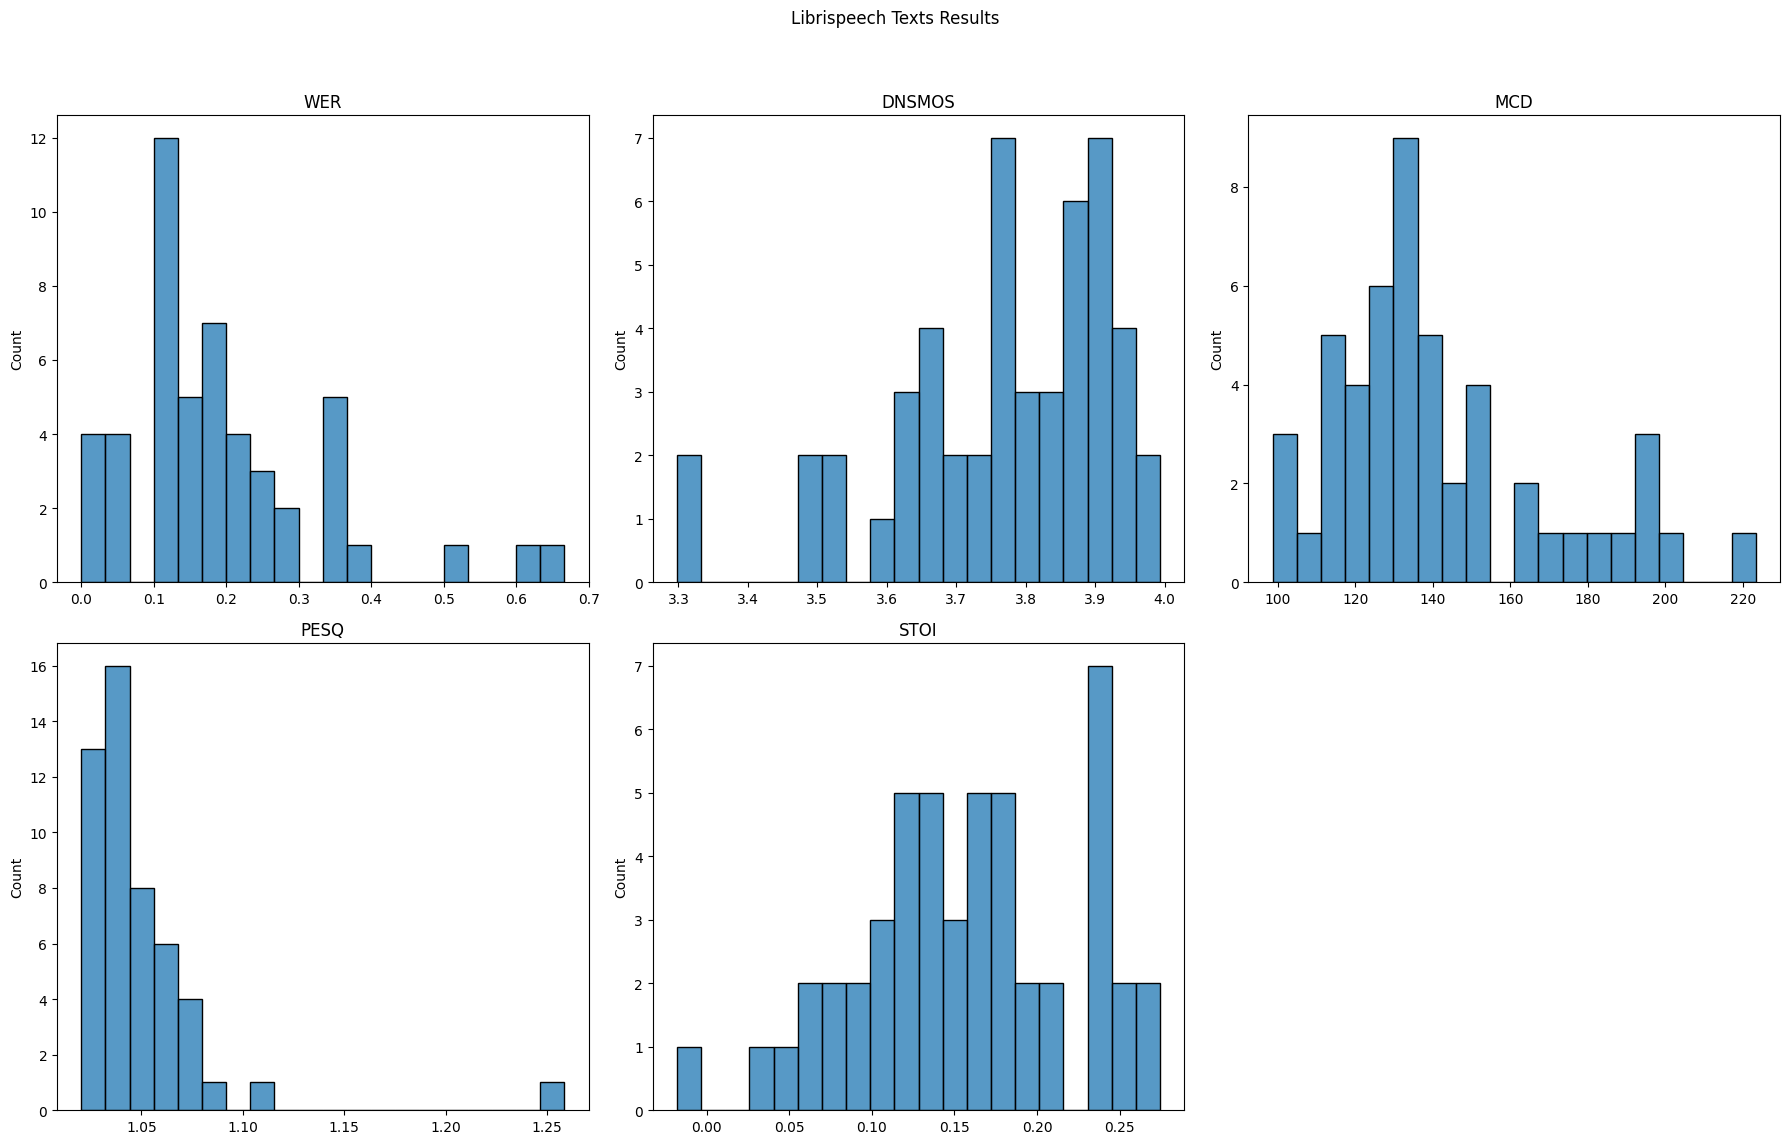

In [ ]:
visualize_results(librispeech_results, "Librispeech Texts Results")

### Графики для Jenny

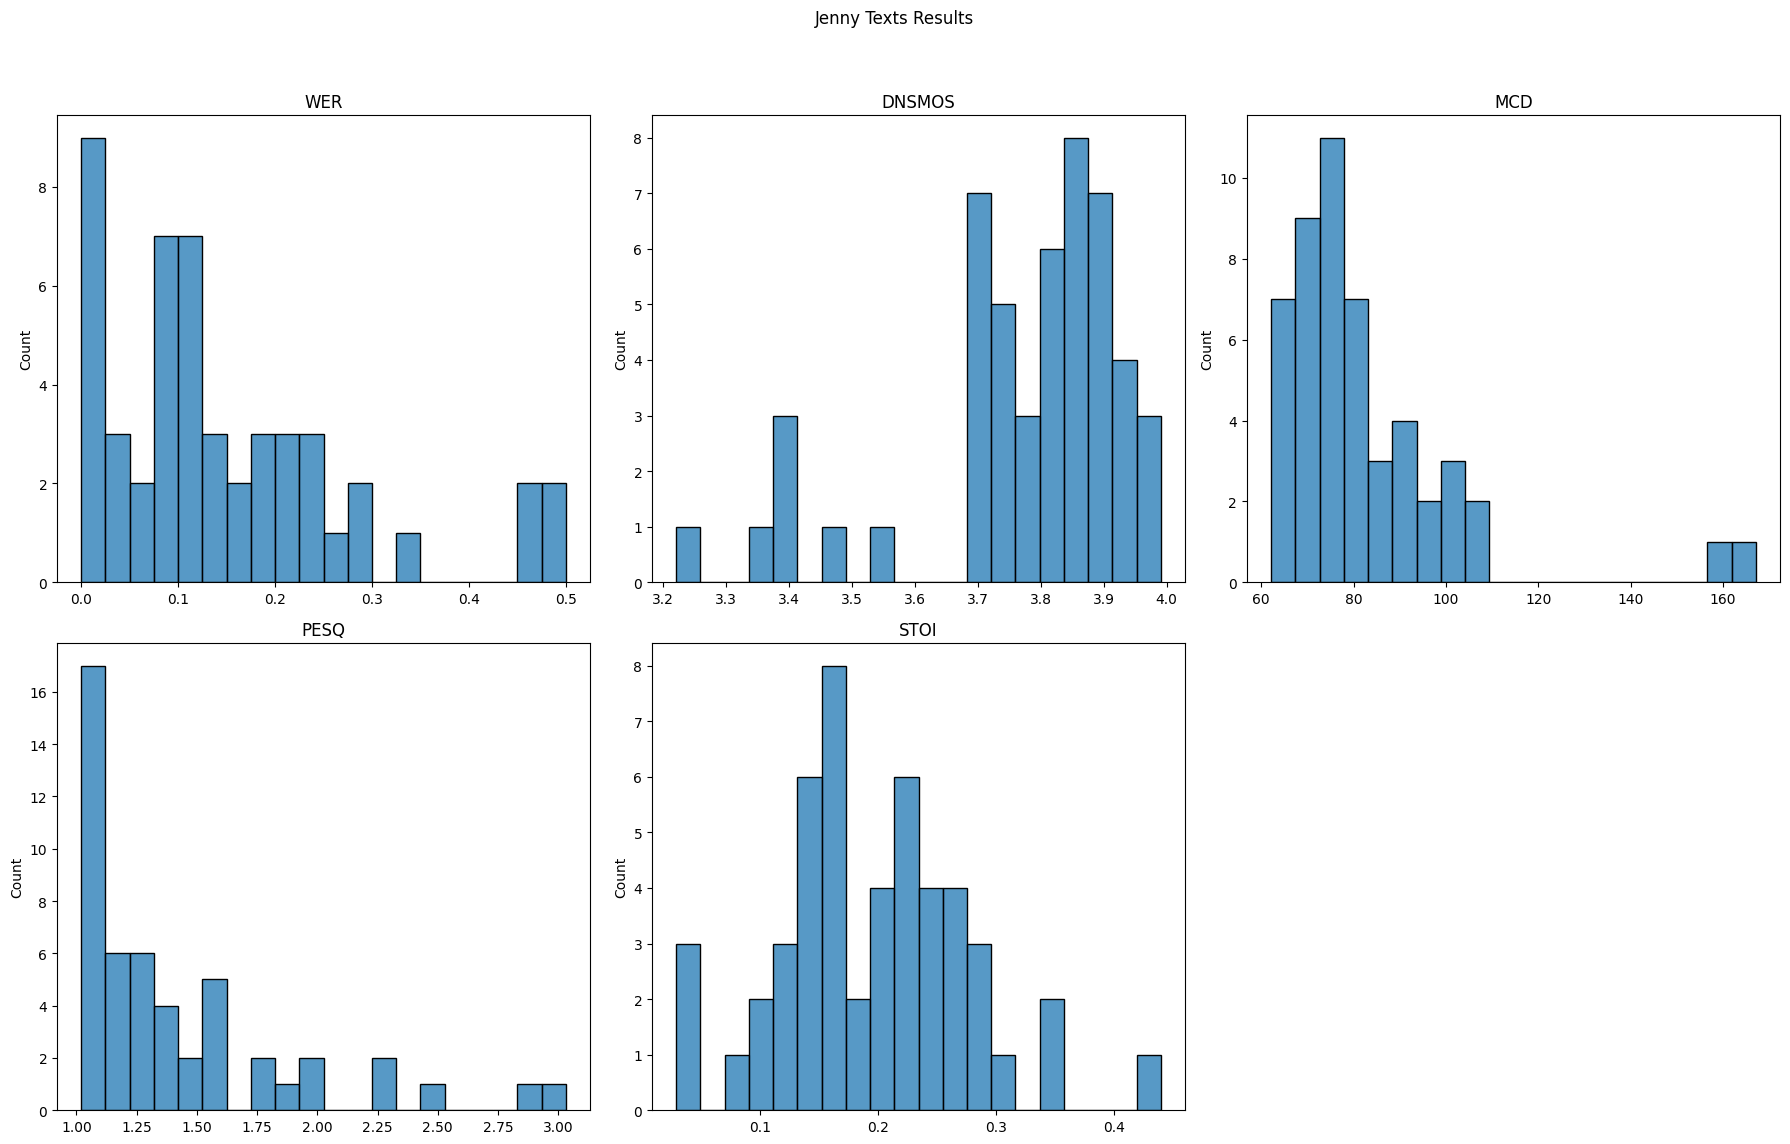

In [ ]:
visualize_results(jenny_results, "Jenny Texts Results")

### Графики для ручных текстов

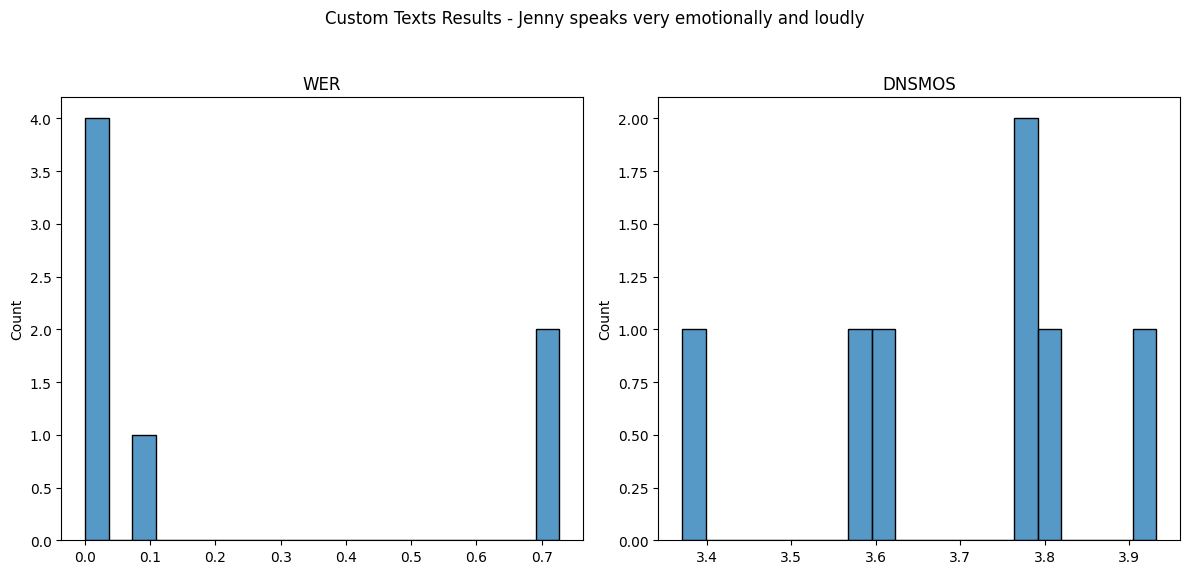

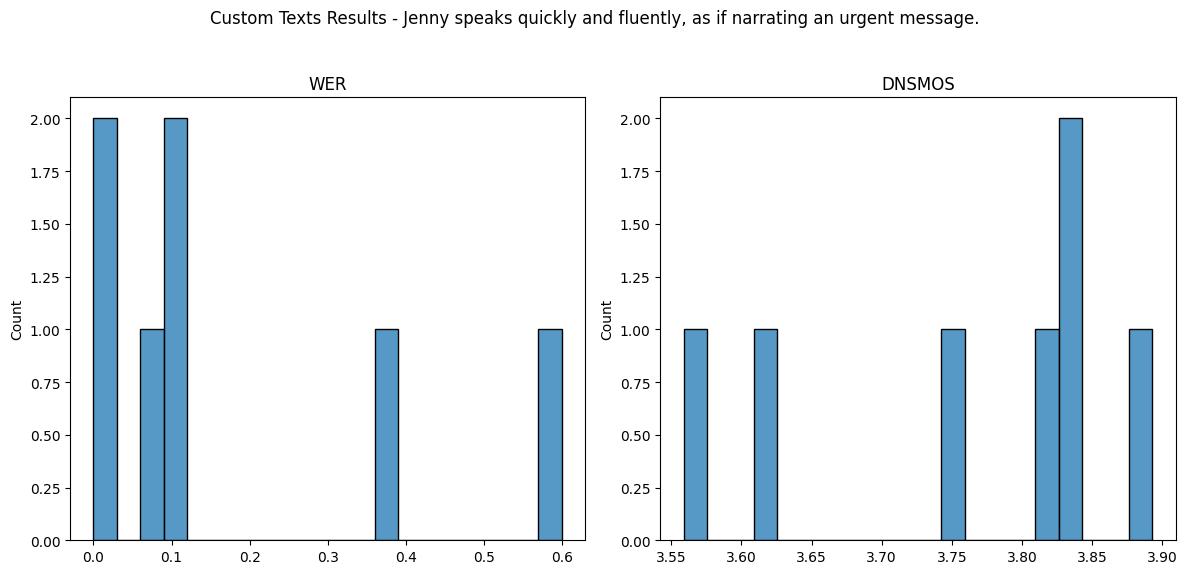

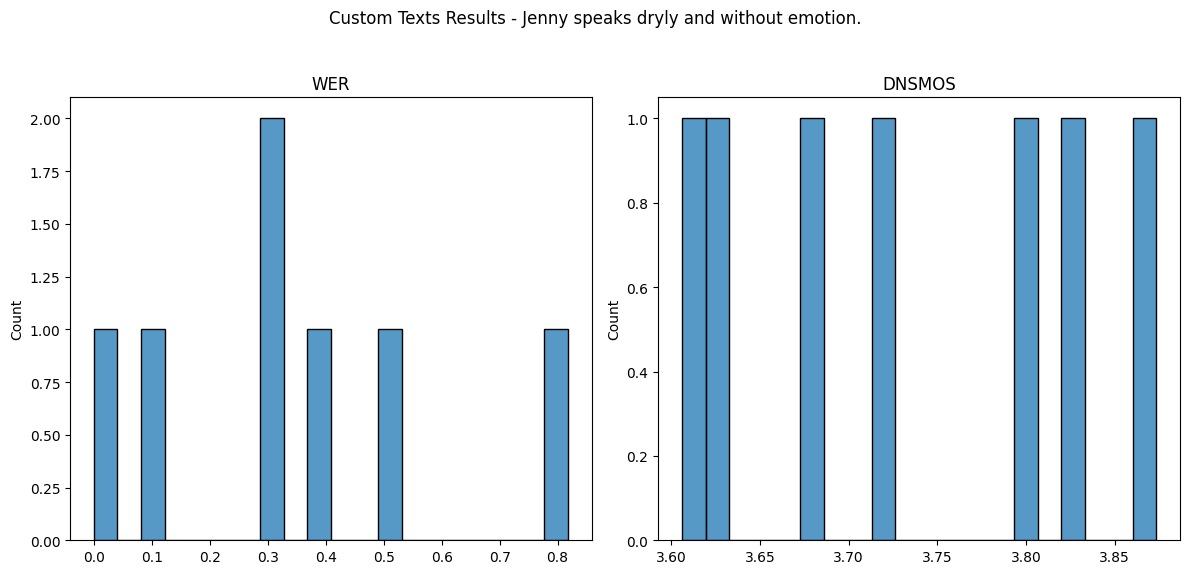

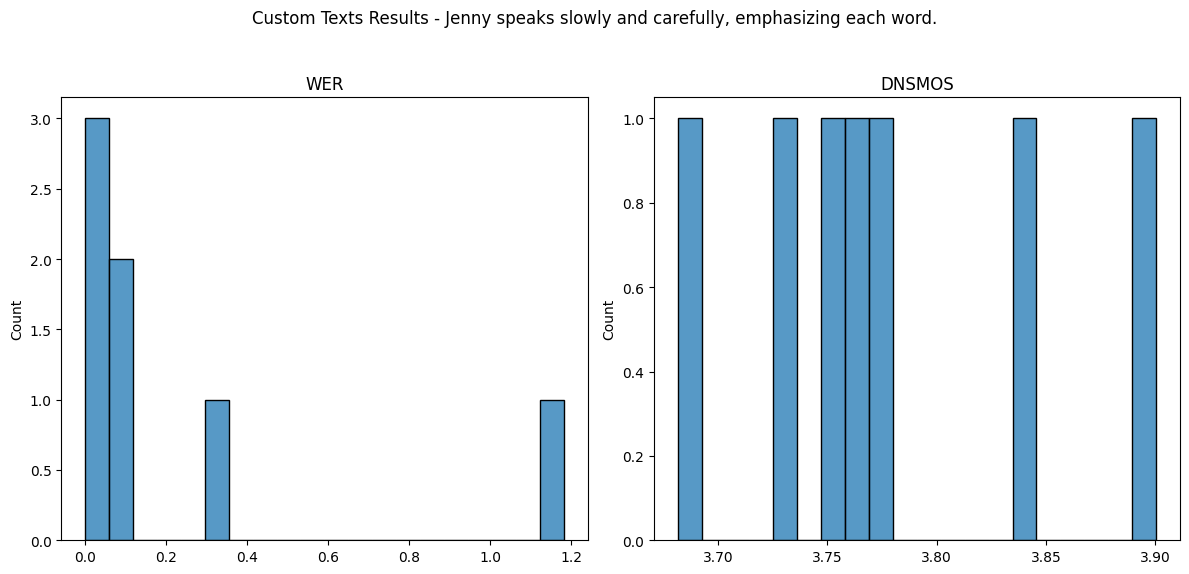

In [ ]:
# Визуализация для custom_texts с разбивкой по описаниям
visualize_custom_texts_results(custom_results, "Custom Texts Results")

## 6. Итоги и вывод

In [ ]:
# Создание итоговой таблицы
summary_metrics = {
    "Dataset": ["Custom Texts", "Jenny Texts", "Librispeech Texts"],
    "Mean WER": [
        custom_df["WER"].mean(),
        jenny_df["WER"].mean(),
        librispeech_df["WER"].mean()
    ],
    "Mean DNSMOS": [
        custom_df["DNSMOS"].mean(),
        jenny_df["DNSMOS"].mean(),
        librispeech_df["DNSMOS"].mean()
    ],
    "Mean MCD": [
        custom_df["MCD"].mean() if "MCD" in custom_df.columns and not custom_df["MCD"].isnull().all() else None,
        jenny_df["MCD"].mean() if "MCD" in jenny_df.columns and not jenny_df["MCD"].isnull().all() else None,
        librispeech_df["MCD"].mean() if "MCD" in librispeech_df.columns and not librispeech_df["MCD"].isnull().all() else None
    ],
    "Mean PESQ": [
        custom_df["PESQ"].mean() if "PESQ" in custom_df.columns and not custom_df["PESQ"].isnull().all() else None,
        jenny_df["PESQ"].mean() if "PESQ" in jenny_df.columns and not jenny_df["PESQ"].isnull().all() else None,
        librispeech_df["PESQ"].mean() if "PESQ" in librispeech_df.columns and not librispeech_df["PESQ"].isnull().all() else None
    ],
    "Mean STOI": [
        custom_df["STOI"].mean() if "STOI" in custom_df.columns and not custom_df["STOI"].isnull().all() else None,
        jenny_df["STOI"].mean() if "STOI" in jenny_df.columns and not jenny_df["STOI"].isnull().all() else None,
        librispeech_df["STOI"].mean() if "STOI" in librispeech_df.columns and not librispeech_df["STOI"].isnull().all() else None
    ],
}

summary_df = pd.DataFrame(summary_metrics)
summary_df.to_csv("summary_metrics.csv", index=False)
print("\nSummary Metrics Table:")
print(summary_df)


Summary Metrics Table:
             Dataset  Mean WER  Mean DNSMOS    Mean MCD  Mean PESQ  Mean STOI
0       Custom Texts  0.245687     3.741049         NaN        NaN        NaN
1        Jenny Texts  0.145817     3.769035   82.362813   1.422405   0.193995
2  Librispeech Texts  0.191006     3.765238  141.612126   1.048656   0.156246


### Вывод

Модель очень хорошо озвучивает тексты, при грамотном подборе описания результаты впечатляют. Основные трудности включают подбор этих описаний, невозможность работы с цифрами и аббревиатурами, также модель вводит в ступор другой язык с латинским алфавитом. Но в среднем модель очень хороша.

WER (Word Error Rate): Оценивает точность распознавания сгенерированного аудио.

DNSMOS (Deep Noise Suppression Mean Opinion Score): Оценивает качество звука и отсутствие шума.

MCD (Mel-Cepstral Distortion): Измеряет расстояние между мел-цефтроструктурами эталонного и сгенерированного аудио.

PESQ (Perceptual Evaluation of Speech Quality): Оценивает восприимчивое качество звука.

STOI (Short-Time Objective Intelligibility): Оценивает интеллектуальную понятность синтезированного аудио.


Датасет Jenny ожидаемо показал лучший результат метрики WER, на Librispeech эта метрика хуже, но на вполне нормальном уровне. На кастомных текстах очевидно прослеживается связь между описанием и качеством метрики WER, чем быстрее и эмоциональнее, тем лучше. Не до конца понятно почему так, это может быть связано как с особенностями модели Whisper, так и с особенностями тренировочного датасета Jenny, либо я подобрал такие тексты. На эту тему нужны дальнейшие исследования. Но в целом метрика на хорошем уровне.

DNSMOS и PESQ везде очень хороши, модель генерирует хорошую речь.

MCD и STOI показывают отвратительный результат, при том что метрики собственно качества речи очень хороши. Это может быть связано с разницей в тембре, скорости произношения и эмоциональной окраске текстов. По идее каждому тексту надо подбирать свое описание, ведь странно произносить диалог из книги и описание цветка одним стилем. Оригинальный датасет Jenny содержит разнообразные стили озвучивания, включая новые заголовки газет, транскрипты видео, книги и другие материалы. Описание должно отражать этот разнообразие.